In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xgboost as xgb
# check version number
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from bayes_opt import BayesianOptimization

In [2]:
train = pd.read_csv('../../Data/Processed/train.csv')
val = pd.read_csv('../../Data/Processed/val.csv')
test = pd.read_csv('../../Data/Processed/test.csv')


In [3]:
test = test.set_index('SK_ID_CURR')

In [3]:
train = train.set_index('SK_ID_CURR')
val = val.set_index('SK_ID_CURR')

In [12]:
full  = pd.concat([train, val], axis = 0)

In [6]:
train.AMT_CREDIT

SK_ID_CURR
100002   -0.475080
100003    1.925097
100004   -1.210088
100006   -0.729237
100007   -0.187130
            ...   
456248   -0.677176
456252   -0.845964
456253    0.258491
456254   -0.573832
456255    0.251281
Name: AMT_CREDIT, Length: 246008, dtype: float64

In [7]:
y_train = train['TARGET']
y_test = val['TARGET']
cols = list(train.columns)
cols.remove('TARGET')
X_train = train[cols]
X_test = val[cols]


In [8]:
def grid_search(model, params, X, y):
    
    cv = GridSearchCV(model, params, cv = 3)
    cv.fit(X, y)
    
    return cv.best_params_

def train_model(model, X, y):
    model.fit(X, y)
    y_pred = model.predict(X)
    
    return model

def get_scores(model, X, y):
    y_pred = model.predict(X)
    print(classification_report(y, y_pred))

def get_output(model, X):
    
    ypred =model.predict_proba(X)
    
    return ypred

def get_auc(model, X, y):
    
    
    y_pred = get_output(model, X)
    return roc_auc_score(y, y_pred[:,1])

    

In [15]:
clf = RandomForestClassifier()
params = {'max_depth' : [25, 35], 'min_samples_split' : [100], 'criterion' : ['gini'], 'n_estimators' : [1000, 750], 'class_weight' : ['balanced']}
best_params = grid_search(clf, params, X_train, y_train)
print("Best Params are:", best_params)
clf = RandomForestClassifier(**best_params)

clf = train_model(clf, X_train, y_train)

print("Training Scores")
get_scores(clf, X_train, y_train)

print("Testing Scores")
get_scores(clf, X_test, y_test)

Best Params are: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 35, 'min_samples_split': 100, 'n_estimators': 1000}
Training Scores
              precision    recall  f1-score   support

           0       0.98      0.91      0.95    226148
           1       0.45      0.81      0.58     19860

    accuracy                           0.91    246008
   macro avg       0.72      0.86      0.76    246008
weighted avg       0.94      0.91      0.92    246008

Testing Scores
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.24      0.38      0.30      4965

    accuracy                           0.86     61503
   macro avg       0.59      0.64      0.61     61503
weighted avg       0.89      0.86      0.87     61503



In [21]:
from sklearn.metrics import confusion_matrix

In [29]:

def get_cm(model, X, y):
    y_pred = model.predict(X)
    return confusion_matrix(y, y_pred)
tn, fp, fn, tp =  get_cm(clf, X_test, y_test).ravel()

In [32]:
get_cm(clf, X_test, y_test)

array([[50715,  5823],
       [ 3078,  1887]], dtype=int64)

In [30]:
tp/(tp + fn)

0.38006042296072506

In [37]:
Gains = tp / (fn + tp)

In [38]:
Gains

0.38006042296072506

In [35]:
lost_opportunity = fp/(tn + fp)

In [36]:
lost_opportunity

0.10299267749124483

In [33]:
fn

3078

In [26]:
50715/(50715+ 3078)

0.9427806591935753

In [27]:
1887/(1887 + 5823)

0.24474708171206225

In [20]:
best_params = {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 35, 'min_samples_split': 100, 'n_estimators': 1000}
clf = RandomForestClassifier(**best_params)

clf = train_model(clf, X_train, y_train)

print("Training Scores")
get_scores(clf, X_train, y_train)

print("Testing Scores")
get_scores(clf, X_test, y_test)

Training Scores
              precision    recall  f1-score   support

           0       0.98      0.91      0.95    226148
           1       0.45      0.81      0.58     19860

    accuracy                           0.91    246008
   macro avg       0.72      0.86      0.76    246008
weighted avg       0.94      0.91      0.92    246008

Testing Scores
              precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.24      0.38      0.30      4965

    accuracy                           0.86     61503
   macro avg       0.59      0.64      0.61     61503
weighted avg       0.89      0.86      0.87     61503



In [14]:
get_scores(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     56538
           1       0.24      0.40      0.30      4965

    accuracy                           0.85     61503
   macro avg       0.59      0.64      0.61     61503
weighted avg       0.89      0.85      0.87     61503



In [12]:
y_test.shape

(61503,)

In [42]:
lgbm = LGBMClassifier(boosting_type='dart',  objective='binary', num_boost_round=2000, learning_rate=0.05, metric='auc', max_depth = 20, n_estimators = 10000, subsample=0.8715623, num_leaves=34, min_split_gain=0.0222415,
params = {'class_weight' : ['balanced'], 'reg_alpha' : [1]}
best_params = grid_search(lgbm, params, X_train, y_train)
print("Best Params are:", best_params)
lgbm = LGBMClassifier(**best_params)

lgbm = train_model(lgbm, X_train, y_train)

print("Training Scores")
get_scores(lgbm, X_train, y_train)

print("Testing Scores")
get_scores(lgbm, X_test, y_test)

C:\Users\siyer\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] num_iterations is set=2000, num_boost_round=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leav

In [41]:
get_auc(lgbm, X_test, y_test)

ROC 0.7609485579074036


In [27]:
columns= [i.replace(':', '') for i in list(X_train.columns)]
columns= [i.replace(' ', '') for i in columns]


In [28]:
X_train.columns = columns
X_test.columns = columns


In [9]:
def objective(n_estimators, learning_rate, num_leaves, colsample_bytree, subsample,max_depth, reg_alpha, reg_lambda, min_split_gain, min_child_weight):
    
    #lgbm.fit(X_train, y_train)
    #print(**hyperparameters)
    
    params = {
        'n_estimators': int(n_estimators) , 
        'learning_rate': learning_rate, 
        'num_leaves' : int(num_leaves), 
        'colsample_bytree' : colsample_bytree, 
        'subsample' : subsample,
        'max_depth' : int(max_depth), 
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'min_split_gain' :min_split_gain,
        'min_child_weight': min_child_weight
    }
    
    lgbm = LGBMClassifier(**params)
    lgbm.fit(X_train, y_train)

    return get_auc(lgbm, X_test, y_test)

In [59]:
pbounds = {'n_estimators': (1000, 10000), 'learning_rate': (0.01, 0.6), 'num_leaves' : (10, 100), 'colsample_bytree' : (0.7, 1), 'subsample' : (0.7, 1), 'max_depth' : (6, 50), 'reg_alpha' : (0, 1), 'reg_lambda' : (0, 1), 'min_split_gain' : (0, 1),'min_child_weight': (0, 1000)}

In [60]:
pbounds


{'n_estimators': (1000, 10000),
 'learning_rate': (0.01, 0.6),
 'num_leaves': (10, 100),
 'colsample_bytree': (0.7, 1),
 'subsample': (0.7, 1),
 'max_depth': (6, 50),
 'reg_alpha': (0, 1),
 'reg_lambda': (0, 1),
 'min_split_gain': (0, 1),
 'min_child_weight': (0, 1000)}

In [72]:

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)

In [74]:
optimizer.maximize(
    init_points=5,
    n_iter=1000,
)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  106      |  0.7574   |  0.7058   |  0.4105   |  15.31    |  265.5    |  0.4916   |  1.48e+03 |  61.67    |  0.1467   |  0.5893   |  0.9099   |
|  107      |  0.7341   |  0.7307   |  0.2543   |  36.55    |  414.2    |  0.04995  |  5.823e+0 |  69.74    |  0.5149   |  0.9446   |  0.876    |
|  108      |  0.7664   |  0.971    |  0.09111  |  12.13    |  807.4    |  0.3977   |  2.488e+0 |  93.48    |  0.3478   |  0.7508   |  0.9178   |
|  109      |  0.7534   |  0.965    |  0.378    |  39.04    |  348.9    |  0.2699   |  9.063e+0 |  48.53    |  0.9648   |  0.6634   |  0.8865   |
|  110      |  0.7529   |  0.7344   |  0.5702   |  25.8     |  578.4    |  0.4081   |  3.133e+0 |  91.3     |  0.5737   |  0

|  139      |  0.7555   |  0.8323   |  0.5733   |  39.93    |  542.7    |  0.7766   |  3.876e+0 |  32.93    |  0.7771   |  0.01974  |  0.927    |
|  140      |  0.7656   |  0.754    |  0.08001  |  11.79    |  498.1    |  0.3798   |  3.83e+03 |  44.78    |  0.576    |  0.3719   |  0.8978   |
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
|  141      |  0.7433   |  0.9448   |  0.5048   |  31.16    |  515.1    |  0.1637   |  3.832e+0 |  31.11    |  0.5651   |  0.1604   |  0.7826   |
|  142      |  0.7633   |  0.7976   |  0.3002   |  11.25    |  474.0    |  0.7061   |  3.835e+0 |  62.22    |  0.6454   |  0.905    |  0.8922   |
|  143      |  0.7529   |  0.9744   |  0.5851   |  45.05    |  775.9    |  0.2542   |  2.471e+0 |  20.45    |  0.7838   |  0.6586   |  0.8415   |
|  144      |  0.7585   |  0.7905   |  0.5617   |  44.16    |  838.8    |  0.5239   |  1.041e+0 |  90.47    |  0.07653  |  0.1216   |  0.996

|  173      |  0.7656   |  0.9212   |  0.01838  |  8.189    |  859.4    |  0.257    |  2.579e+0 |  27.66    |  0.9142   |  0.2707   |  0.8717   |
|  174      |  0.764    |  0.9894   |  0.2102   |  29.08    |  861.2    |  0.262    |  2.591e+0 |  44.76    |  0.4567   |  0.7547   |  0.8702   |
|  175      |  0.7632   |  0.9368   |  0.1367   |  46.47    |  727.5    |  0.9881   |  2.525e+0 |  14.48    |  0.137    |  0.8244   |  0.8254   |
|  176      |  0.7619   |  0.7768   |  0.4823   |  44.22    |  769.5    |  0.6735   |  2.517e+0 |  10.17    |  0.972    |  0.553    |  0.8754   |
|  177      |  0.7642   |  0.8024   |  0.07221  |  11.31    |  763.7    |  0.8575   |  1.015e+0 |  89.18    |  0.7253   |  0.922    |  0.9208   |
|  178      |  0.7595   |  0.9433   |  0.5406   |  9.041    |  882.0    |  0.3474   |  2.578e+0 |  38.39    |  0.5818   |  0.6093   |  0.8649   |
|  179      |  0.7602   |  0.9131   |  0.5148   |  11.57    |  823.5    |  0.4074   |  1.044e+0 |  75.91    |  0.922    |  0

|  207      |  0.7656   |  0.7587   |  0.1097   |  13.36    |  551.5    |  0.4713   |  3.898e+0 |  19.86    |  0.08103  |  0.05001  |  0.8331   |
|  208      |  0.7666   |  0.8689   |  0.0163   |  25.27    |  651.5    |  0.1196   |  2.511e+0 |  13.29    |  0.6981   |  0.7985   |  0.7861   |
|  209      |  0.7574   |  0.9815   |  0.5243   |  7.528    |  512.6    |  0.3308   |  3.854e+0 |  40.52    |  0.9008   |  0.08666  |  0.9678   |
|  210      |  0.764    |  0.9385   |  0.07924  |  8.033    |  583.8    |  0.9587   |  3.881e+0 |  99.6     |  0.3164   |  0.7581   |  0.7044   |
|  211      |  0.7617   |  0.8362   |  0.1488   |  37.23    |  651.1    |  0.1397   |  2.516e+0 |  43.04    |  0.9803   |  0.7885   |  0.9489   |
|  212      |  0.7595   |  0.9879   |  0.5565   |  32.83    |  558.8    |  0.31     |  3.889e+0 |  10.7     |  0.8876   |  0.5564   |  0.943    |
|  213      |  0.7642   |  0.7712   |  0.2406   |  17.23    |  769.0    |  0.5672   |  1.029e+0 |  80.61    |  0.9677   |  0

|  241      |  0.7642   |  0.8073   |  0.1364   |  9.55     |  854.1    |  0.1428   |  2.584e+0 |  50.07    |  0.5604   |  0.3487   |  0.9347   |
|  242      |  0.7554   |  0.7979   |  0.4716   |  14.89    |  858.8    |  0.2484   |  2.564e+0 |  57.26    |  0.5011   |  0.6251   |  0.8545   |
|  243      |  0.7666   |  0.7386   |  0.03216  |  42.46    |  681.1    |  0.341    |  2.529e+0 |  43.54    |  0.7656   |  0.06058  |  0.8109   |
|  244      |  0.7667   |  0.7492   |  0.01823  |  20.0     |  617.5    |  0.366    |  2.592e+0 |  86.09    |  0.2567   |  0.4543   |  0.9064   |
|  245      |  0.7625   |  0.919    |  0.3145   |  22.27    |  770.8    |  0.7272   |  1.006e+0 |  91.23    |  0.4022   |  0.1581   |  0.7801   |
|  246      |  0.7591   |  0.7856   |  0.5007   |  42.75    |  793.0    |  0.9102   |  1.037e+0 |  57.49    |  0.6519   |  0.9549   |  0.8724   |
|  247      |  0.7591   |  0.8788   |  0.463    |  10.2     |  662.3    |  0.9163   |  2.68e+03 |  95.37    |  0.9847   |  0

|  274      |  0.7202   |  0.8602   |  0.5933   |  26.29    |  183.1    |  0.2593   |  2.405e+0 |  88.18    |  0.03183  |  0.9445   |  0.8439   |
|  275      |  0.7648   |  0.9032   |  0.1697   |  22.87    |  719.1    |  0.6696   |  7.032e+0 |  28.06    |  0.02527  |  0.7379   |  0.7325   |
|  276      |  0.7655   |  0.8673   |  0.1202   |  12.46    |  100.5    |  0.3671   |  2.048e+0 |  37.93    |  0.9721   |  0.1002   |  0.8289   |
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
|  277      |  0.7035   |  0.8536   |  0.5747   |  7.11     |  122.6    |  0.06666  |  3.565e+0 |  31.25    |  0.7143   |  0.6881   |  0.9076   |
|  278      |  0.7663   |  0.8729   |  0.01604  |  33.94    |  323.0    |  0.2579   |  3.223e+0 |  38.59    |  0.5885   |  0.2686   |  0.7639   |
|  279      |  0.7663   |  0.8871   |  0.05888  |  18.54    |  690.9    |  0.2652   |  7.413e+0 |  82.53    |  0.5875   |  0.1499   |  0.936

|  308      |  0.7549   |  0.9677   |  0.4088   |  13.93    |  90.06    |  0.9776   |  9.198e+0 |  58.57    |  0.2323   |  0.7483   |  0.9957   |
|  309      |  0.7628   |  0.8993   |  0.3163   |  26.43    |  655.1    |  0.6046   |  3.622e+0 |  55.77    |  0.4353   |  0.9742   |  0.8801   |
|  310      |  0.761    |  0.7143   |  0.4366   |  32.98    |  901.8    |  0.793    |  3.396e+0 |  37.36    |  0.8645   |  0.9821   |  0.887    |
|  311      |  0.7422   |  0.7908   |  0.3727   |  49.48    |  367.3    |  0.143    |  1.479e+0 |  76.08    |  0.7442   |  0.01105  |  0.7634   |
|  312      |  0.765    |  0.957    |  0.1515   |  33.73    |  714.0    |  0.7273   |  2.948e+0 |  46.9     |  0.5281   |  0.09418  |  0.7775   |
|  313      |  0.7649   |  0.8821   |  0.1728   |  6.575    |  683.2    |  0.359    |  6.308e+0 |  96.28    |  0.4922   |  0.4086   |  0.7662   |
|  314      |  0.7576   |  0.9419   |  0.5906   |  10.21    |  648.5    |  0.5208   |  4.653e+0 |  56.75    |  0.9994   |  0

|  342      |  0.7623   |  0.7143   |  0.369    |  27.1     |  631.2    |  0.8942   |  6.505e+0 |  12.96    |  0.3514   |  0.604    |  0.8235   |
|  343      |  0.7471   |  0.8554   |  0.06582  |  15.82    |  141.1    |  0.04189  |  4.231e+0 |  50.53    |  0.1102   |  0.1727   |  0.9051   |
|  344      |  0.7499   |  0.9187   |  0.2009   |  10.41    |  7.462    |  0.4209   |  2.036e+0 |  75.07    |  0.5614   |  0.9173   |  0.731    |
|  345      |  0.7606   |  0.7095   |  0.2974   |  32.05    |  429.7    |  0.2878   |  6.132e+0 |  55.29    |  0.02711  |  0.2463   |  0.8087   |
|  346      |  0.7656   |  0.7855   |  0.03749  |  14.59    |  686.2    |  0.4572   |  1.774e+0 |  36.94    |  0.9326   |  0.5285   |  0.8572   |
|  347      |  0.7626   |  0.7276   |  0.1017   |  30.57    |  528.2    |  0.1568   |  7.551e+0 |  49.65    |  0.03053  |  0.9838   |  0.7965   |
|  348      |  0.7622   |  0.8666   |  0.2703   |  11.64    |  427.9    |  0.3077   |  1.762e+0 |  80.68    |  0.1473   |  0

|  376      |  0.7659   |  0.8605   |  0.06003  |  23.26    |  190.3    |  0.8483   |  8.004e+0 |  88.61    |  0.1348   |  0.593    |  0.897    |
|  377      |  0.7583   |  0.8976   |  0.5862   |  49.72    |  982.5    |  0.3871   |  2.631e+0 |  60.07    |  0.3148   |  0.3095   |  0.9704   |
|  378      |  0.7645   |  0.774    |  0.1841   |  16.89    |  484.7    |  0.6146   |  4.813e+0 |  76.61    |  0.2837   |  0.5112   |  0.9248   |
|  379      |  0.7631   |  0.859    |  0.2342   |  22.75    |  368.3    |  0.4578   |  5.777e+0 |  66.41    |  0.129    |  0.9641   |  0.9401   |
|  380      |  0.7099   |  0.9056   |  0.5697   |  45.27    |  71.39    |  0.1583   |  3.31e+03 |  34.58    |  0.5719   |  0.07132  |  0.8497   |
|  381      |  0.7576   |  0.777    |  0.4339   |  8.865    |  830.2    |  0.1706   |  6.289e+0 |  23.76    |  0.3072   |  0.05147  |  0.8578   |
|  382      |  0.7646   |  0.7799   |  0.08798  |  33.9     |  680.9    |  0.804    |  9.826e+0 |  34.21    |  0.7983   |  0

|  410      |  0.7603   |  0.7289   |  0.5149   |  31.93    |  335.5    |  0.6188   |  3.664e+0 |  13.31    |  0.8554   |  0.9398   |  0.9675   |
|  411      |  0.7652   |  0.8386   |  0.05174  |  42.95    |  393.4    |  0.8859   |  6.176e+0 |  96.02    |  0.5492   |  0.1533   |  0.8259   |
|  412      |  0.7552   |  0.9023   |  0.4495   |  6.569    |  286.0    |  0.2485   |  3.606e+0 |  64.15    |  0.5863   |  0.704    |  0.8965   |
|  413      |  0.7591   |  0.928    |  0.251    |  26.07    |  174.0    |  0.4744   |  2.003e+0 |  72.2     |  0.03849  |  0.1807   |  0.9133   |
|  414      |  0.7635   |  0.9985   |  0.2434   |  22.0     |  739.6    |  0.9841   |  6.405e+0 |  25.66    |  0.2445   |  0.9635   |  0.9935   |
|  415      |  0.7416   |  0.7908   |  0.4901   |  12.78    |  416.3    |  0.1601   |  6.985e+0 |  42.46    |  0.5805   |  0.8123   |  0.7756   |
|  416      |  0.7495   |  0.8121   |  0.2375   |  12.88    |  619.2    |  0.08201  |  5.936e+0 |  68.48    |  0.3633   |  0

|  444      |  0.7327   |  0.7607   |  0.5179   |  20.47    |  745.8    |  0.07599  |  3.824e+0 |  28.49    |  0.1192   |  0.8347   |  0.7993   |
|  445      |  0.7318   |  0.8302   |  0.5109   |  41.59    |  324.8    |  0.103    |  2.808e+0 |  22.54    |  0.7726   |  0.6318   |  0.9136   |
|  446      |  0.7632   |  0.9923   |  0.2259   |  42.96    |  948.9    |  0.4302   |  1.546e+0 |  38.39    |  0.4471   |  0.03425  |  0.9202   |
|  447      |  0.7637   |  0.8549   |  0.01181  |  28.02    |  980.9    |  0.588    |  8.152e+0 |  19.29    |  0.9959   |  0.3647   |  0.7571   |
|  448      |  0.7291   |  0.8869   |  0.2935   |  38.7     |  17.29    |  0.1754   |  6.717e+0 |  43.67    |  0.368    |  0.3085   |  0.9834   |
|  449      |  0.7648   |  0.8596   |  0.1477   |  32.57    |  988.3    |  0.3028   |  1.489e+0 |  53.19    |  0.4707   |  0.4269   |  0.7287   |
|  450      |  0.7646   |  0.9776   |  0.1155   |  47.86    |  333.0    |  0.2196   |  1.954e+0 |  24.57    |  0.9596   |  0

|  478      |  0.764    |  0.9319   |  0.08538  |  21.49    |  898.2    |  0.6719   |  5.658e+0 |  12.59    |  0.02893  |  0.5057   |  0.7881   |
|  479      |  0.7612   |  0.8397   |  0.4631   |  13.56    |  836.8    |  0.6983   |  3.296e+0 |  78.55    |  0.7416   |  0.7827   |  0.7409   |
|  480      |  0.764    |  0.8212   |  0.2745   |  45.37    |  523.2    |  0.3374   |  1.52e+03 |  77.16    |  0.8674   |  0.8308   |  0.7608   |
|  481      |  0.7633   |  0.8254   |  0.183    |  24.52    |  272.7    |  0.7393   |  5.159e+0 |  93.08    |  0.8958   |  0.696    |  0.8392   |
|  482      |  0.7469   |  0.7878   |  0.45     |  35.06    |  162.1    |  0.2214   |  1.054e+0 |  17.11    |  0.4116   |  0.8419   |  0.9981   |
|  483      |  0.7325   |  0.7168   |  0.2756   |  40.49    |  667.1    |  0.01432  |  4.257e+0 |  18.71    |  0.2578   |  0.1668   |  0.7758   |
|  484      |  0.7595   |  0.9437   |  0.3689   |  47.78    |  240.5    |  0.8903   |  3.63e+03 |  42.59    |  0.003859 |  0

|  512      |  0.7525   |  0.712    |  0.2711   |  13.1     |  21.41    |  0.5809   |  8.294e+0 |  91.93    |  0.4448   |  0.235    |  0.83     |
|  513      |  0.7629   |  0.7601   |  0.1777   |  47.69    |  799.0    |  0.9566   |  9.793e+0 |  74.21    |  0.8859   |  0.4078   |  0.9313   |
|  514      |  0.7646   |  0.8935   |  0.2123   |  6.23     |  852.6    |  0.2627   |  2.845e+0 |  56.34    |  0.2713   |  0.625    |  0.7145   |
|  515      |  0.7553   |  0.8427   |  0.3283   |  39.43    |  804.5    |  0.1211   |  8.162e+0 |  75.68    |  0.5094   |  0.4592   |  0.7684   |
|  516      |  0.7603   |  0.8034   |  0.4235   |  34.07    |  449.8    |  0.6006   |  7.901e+0 |  15.35    |  0.9708   |  0.1856   |  0.7565   |
|  517      |  0.7545   |  0.7055   |  0.2088   |  47.81    |  383.8    |  0.1254   |  5.04e+03 |  68.88    |  0.424    |  0.1838   |  0.7804   |
|  518      |  0.7197   |  0.7438   |  0.2766   |  44.79    |  545.9    |  0.01565  |  5.979e+0 |  24.82    |  0.5622   |  0

|  546      |  0.7093   |  0.7152   |  0.5943   |  34.14    |  101.1    |  0.1706   |  6.865e+0 |  44.2     |  0.212    |  0.8006   |  0.816    |
|  547      |  0.7633   |  0.8726   |  0.1573   |  33.66    |  841.5    |  0.9256   |  6.924e+0 |  97.61    |  0.08936  |  0.3736   |  0.8244   |
|  548      |  0.7654   |  0.8292   |  0.1232   |  32.16    |  670.5    |  0.3136   |  5.535e+0 |  91.43    |  0.5376   |  0.4091   |  0.8065   |
|  549      |  0.7504   |  0.7682   |  0.4403   |  22.86    |  906.9    |  0.0906   |  1.721e+0 |  72.44    |  0.7916   |  0.9543   |  0.7789   |
|  550      |  0.7351   |  0.7924   |  0.3404   |  28.02    |  893.5    |  0.03075  |  4.621e+0 |  35.11    |  0.6705   |  0.564    |  0.9023   |
|  551      |  0.7576   |  0.9784   |  0.5806   |  8.261    |  491.8    |  0.9402   |  6.593e+0 |  91.3     |  0.2176   |  0.6669   |  0.7157   |
|  552      |  0.7597   |  0.9181   |  0.5655   |  37.14    |  907.0    |  0.5327   |  2.573e+0 |  54.3     |  0.2955   |  0

|  580      |  0.7543   |  0.7801   |  0.4463   |  7.854    |  628.8    |  0.194    |  2.64e+03 |  15.61    |  0.1336   |  0.1813   |  0.8932   |
|  581      |  0.7574   |  0.9189   |  0.4345   |  46.3     |  321.5    |  0.8702   |  8.817e+0 |  78.86    |  0.9422   |  0.9245   |  0.9614   |
|  582      |  0.7624   |  0.8538   |  0.276    |  24.84    |  558.6    |  0.5244   |  5.49e+03 |  62.09    |  0.5105   |  0.6393   |  0.7192   |
|  583      |  0.7614   |  0.7501   |  0.2221   |  19.49    |  92.24    |  0.5539   |  6.289e+0 |  36.25    |  0.3364   |  0.9395   |  0.9123   |
|  584      |  0.7612   |  0.8427   |  0.301    |  46.97    |  326.5    |  0.5024   |  8.906e+0 |  44.68    |  0.1686   |  0.6839   |  0.9412   |
|  585      |  0.7616   |  0.9497   |  0.3783   |  10.22    |  729.0    |  0.8161   |  3.606e+0 |  57.33    |  0.1985   |  0.256    |  0.8367   |
|  586      |  0.7537   |  0.734    |  0.5289   |  23.78    |  796.3    |  0.2114   |  1.027e+0 |  95.96    |  0.3907   |  0

|  614      |  0.7649   |  0.9349   |  0.1178   |  46.89    |  425.8    |  0.2856   |  6.111e+0 |  51.4     |  0.1568   |  0.1092   |  0.8053   |
|  615      |  0.7658   |  0.7561   |  0.03507  |  22.75    |  817.5    |  0.02515  |  1.622e+0 |  76.59    |  0.03638  |  0.6015   |  0.9973   |
|  616      |  0.7574   |  0.9517   |  0.509    |  33.73    |  416.4    |  0.8411   |  2.839e+0 |  54.9     |  0.7871   |  0.08426  |  0.8039   |
|  617      |  0.7591   |  0.8627   |  0.0623   |  39.03    |  113.8    |  0.1002   |  5.23e+03 |  46.74    |  0.148    |  0.6534   |  0.8541   |
|  618      |  0.7614   |  0.76     |  0.3212   |  19.7     |  769.7    |  0.7272   |  1.037e+0 |  95.0     |  0.2689   |  0.2445   |  0.953    |
|  619      |  0.748    |  0.7778   |  0.5999   |  20.22    |  230.1    |  0.579    |  7.235e+0 |  44.7     |  0.4145   |  0.3023   |  0.8478   |
|  620      |  0.7546   |  0.8383   |  0.4994   |  34.56    |  214.5    |  0.4419   |  6.917e+0 |  23.45    |  0.2851   |  0

|  648      |  0.7618   |  0.8233   |  0.3919   |  37.12    |  980.8    |  0.5277   |  7.095e+0 |  68.46    |  0.9654   |  0.5886   |  0.9836   |
|  649      |  0.7219   |  0.9897   |  0.177    |  7.96     |  182.6    |  0.01793  |  6.994e+0 |  58.57    |  0.02307  |  0.9613   |  0.7037   |
|  650      |  0.7482   |  0.9502   |  0.2357   |  28.55    |  161.6    |  0.05384  |  1.368e+0 |  15.28    |  0.000826 |  0.7287   |  0.8891   |
|  651      |  0.7621   |  0.8273   |  0.2902   |  16.79    |  784.6    |  0.6986   |  1.016e+0 |  80.57    |  0.3784   |  0.8411   |  0.8137   |
|  652      |  0.7665   |  0.9293   |  0.02126  |  40.88    |  705.5    |  0.004724 |  2.613e+0 |  23.95    |  0.8351   |  0.7294   |  0.7598   |
|  653      |  0.7629   |  0.968    |  0.263    |  42.11    |  983.2    |  0.343    |  2.717e+0 |  32.35    |  0.1966   |  0.2092   |  0.7814   |
|  654      |  0.7643   |  0.7389   |  0.2041   |  6.827    |  772.4    |  0.5844   |  1.038e+0 |  73.3     |  0.379    |  0

|  682      |  0.7621   |  0.8074   |  0.2527   |  32.06    |  199.3    |  0.5901   |  6.89e+03 |  57.64    |  0.8442   |  0.5421   |  0.8296   |
|  683      |  0.7622   |  0.8713   |  0.4421   |  24.19    |  646.0    |  0.7333   |  9.628e+0 |  63.11    |  0.1062   |  0.4521   |  0.7197   |
|  684      |  0.7427   |  0.8148   |  0.3636   |  25.09    |  102.7    |  0.2543   |  9.718e+0 |  75.72    |  0.8045   |  0.9079   |  0.8659   |
|  685      |  0.7551   |  0.7238   |  0.4883   |  9.076    |  938.2    |  0.2208   |  6.351e+0 |  64.99    |  0.1953   |  0.6028   |  0.9806   |
|  686      |  0.7499   |  0.9692   |  0.433    |  43.79    |  78.67    |  0.6689   |  5.306e+0 |  77.65    |  0.465    |  0.5108   |  0.8917   |
|  687      |  0.7608   |  0.7622   |  0.4285   |  49.69    |  840.4    |  0.5324   |  4.724e+0 |  14.28    |  0.9706   |  0.6007   |  0.7635   |
|  688      |  0.7636   |  0.728    |  0.2166   |  8.259    |  262.9    |  0.9393   |  3.899e+0 |  34.23    |  0.06045  |  0

|  716      |  0.7643   |  0.8976   |  0.1733   |  14.05    |  469.0    |  0.3821   |  4.538e+0 |  72.46    |  0.06845  |  0.182    |  0.9512   |
|  717      |  0.7597   |  0.7958   |  0.3676   |  17.62    |  790.5    |  0.2588   |  1.039e+0 |  62.45    |  0.4398   |  0.9695   |  0.9392   |
|  718      |  0.7455   |  0.871    |  0.222    |  7.702    |  260.4    |  0.02492  |  1.704e+0 |  62.12    |  0.1352   |  0.6294   |  0.8296   |
|  719      |  0.7631   |  0.8976   |  0.1242   |  47.64    |  404.5    |  0.2317   |  6.121e+0 |  36.54    |  0.1391   |  0.7245   |  0.8418   |
|  720      |  0.7593   |  0.7429   |  0.2487   |  37.07    |  83.62    |  0.5392   |  1.633e+0 |  86.84    |  0.2866   |  0.6318   |  0.7464   |
|  721      |  0.7509   |  0.9766   |  0.3017   |  9.234    |  304.8    |  0.1314   |  7.181e+0 |  57.29    |  0.8243   |  0.4828   |  0.7582   |
|  722      |  0.7629   |  0.9879   |  0.2695   |  46.0     |  948.6    |  0.4039   |  6.262e+0 |  90.48    |  0.3994   |  0

|  750      |  0.7444   |  0.9286   |  0.3323   |  17.52    |  219.7    |  0.1641   |  2.175e+0 |  79.25    |  0.5747   |  0.9528   |  0.948    |
|  751      |  0.7655   |  0.7798   |  0.08603  |  19.24    |  712.6    |  0.1901   |  8.464e+0 |  22.79    |  0.8861   |  0.2428   |  0.8652   |
|  752      |  0.7514   |  0.7317   |  0.4564   |  21.65    |  721.2    |  0.1587   |  6.226e+0 |  89.74    |  0.3825   |  0.3231   |  0.7166   |
|  753      |  0.7658   |  0.7777   |  0.01556  |  8.914    |  651.8    |  0.5043   |  2.585e+0 |  70.34    |  0.8452   |  0.8754   |  0.889    |
|  754      |  0.7618   |  0.7133   |  0.3501   |  31.54    |  631.4    |  0.8365   |  4.046e+0 |  25.06    |  0.4015   |  0.1942   |  0.7833   |
|  755      |  0.7645   |  0.9009   |  0.01942  |  12.29    |  670.2    |  0.8498   |  6.191e+0 |  53.85    |  0.201    |  0.4605   |  0.9225   |
|  756      |  0.7638   |  0.9586   |  0.2056   |  25.1     |  560.9    |  0.4602   |  3.861e+0 |  26.37    |  0.7771   |  0

|  784      |  0.7511   |  0.9588   |  0.4229   |  11.68    |  236.6    |  0.3238   |  8.818e+0 |  51.81    |  0.6931   |  0.2512   |  0.8487   |
|  785      |  0.7569   |  0.8857   |  0.5569   |  46.11    |  516.0    |  0.7531   |  9.983e+0 |  32.51    |  0.972    |  0.3933   |  0.9292   |
|  786      |  0.7602   |  0.8217   |  0.5727   |  14.87    |  803.0    |  0.7584   |  8.901e+0 |  43.99    |  0.6834   |  0.2107   |  0.9205   |
|  787      |  0.7598   |  0.8201   |  0.5308   |  25.95    |  782.3    |  0.9388   |  9.657e+0 |  55.62    |  0.7321   |  0.252    |  0.9817   |
|  788      |  0.7624   |  0.9143   |  0.3716   |  18.3     |  945.5    |  0.6454   |  2.381e+0 |  98.46    |  0.5873   |  0.9547   |  0.9816   |
|  789      |  0.7651   |  0.9499   |  0.09011  |  48.77    |  298.0    |  0.9897   |  5.472e+0 |  29.9     |  0.02569  |  0.07632  |  0.9329   |
|  790      |  0.7551   |  0.741    |  0.5221   |  8.735    |  839.1    |  0.2188   |  2.56e+03 |  22.57    |  0.04998  |  0

|  818      |  0.755    |  0.993    |  0.5609   |  35.59    |  625.6    |  0.417    |  4.406e+0 |  66.12    |  0.7794   |  0.877    |  0.7659   |
|  819      |  0.76     |  0.7331   |  0.1678   |  20.2     |  531.9    |  0.1183   |  9.312e+0 |  38.4     |  0.9241   |  0.4568   |  0.8583   |
|  820      |  0.7635   |  0.8941   |  0.2448   |  24.69    |  848.7    |  0.6293   |  1.757e+0 |  99.79    |  0.3267   |  0.37     |  0.8087   |
|  821      |  0.7629   |  0.7359   |  0.06353  |  12.53    |  951.2    |  0.7248   |  8.348e+0 |  55.4     |  0.2036   |  0.5885   |  0.9054   |
|  822      |  0.7661   |  0.9666   |  0.02309  |  26.52    |  527.9    |  0.2203   |  3.3e+03  |  57.9     |  0.3822   |  0.347    |  0.7039   |
|  823      |  0.7564   |  0.992    |  0.4895   |  31.89    |  512.0    |  0.8801   |  7.586e+0 |  55.46    |  0.9141   |  0.5472   |  0.8454   |
|  824      |  0.763    |  0.7687   |  0.2372   |  23.24    |  731.3    |  0.9373   |  2.521e+0 |  49.56    |  0.4099   |  0

|  852      |  0.7606   |  0.7285   |  0.3133   |  40.8     |  284.9    |  0.3649   |  8.67e+03 |  38.26    |  0.1764   |  0.6843   |  0.7167   |
|  853      |  0.7645   |  0.7931   |  0.114    |  22.89    |  89.98    |  0.4444   |  8.406e+0 |  48.49    |  0.7191   |  0.2464   |  0.8442   |
|  854      |  0.764    |  0.8094   |  0.03246  |  28.92    |  670.2    |  0.1074   |  7.531e+0 |  89.26    |  0.3875   |  0.922    |  0.9102   |
|  855      |  0.7594   |  0.8678   |  0.4173   |  44.39    |  474.2    |  0.6525   |  7.953e+0 |  67.35    |  0.8443   |  0.9283   |  0.8158   |
|  856      |  0.7617   |  0.7374   |  0.3592   |  42.47    |  395.0    |  0.3832   |  6.373e+0 |  16.34    |  0.0148   |  0.03273  |  0.8713   |
|  857      |  0.7371   |  0.9213   |  0.4489   |  18.18    |  978.0    |  0.04259  |  3.695e+0 |  23.29    |  0.7653   |  0.1148   |  0.7451   |
|  858      |  0.7659   |  0.9422   |  0.04584  |  16.56    |  616.4    |  0.5267   |  3.208e+0 |  19.13    |  0.088    |  0

|  886      |  0.7578   |  0.7695   |  0.3575   |  13.31    |  548.8    |  0.2464   |  8.381e+0 |  28.85    |  0.516    |  0.05168  |  0.9292   |
|  887      |  0.7623   |  0.7415   |  0.2661   |  33.92    |  827.1    |  0.5604   |  9.257e+0 |  74.17    |  0.01663  |  0.3016   |  0.9895   |
|  888      |  0.7663   |  0.987    |  0.01669  |  40.88    |  282.4    |  0.882    |  8.373e+0 |  72.41    |  0.5066   |  0.1888   |  0.9089   |
|  889      |  0.7646   |  0.9507   |  0.1765   |  40.69    |  826.0    |  0.2076   |  7.026e+0 |  43.47    |  0.5068   |  0.9277   |  0.9323   |
|  890      |  0.7617   |  0.8467   |  0.2853   |  25.79    |  847.7    |  0.2667   |  6.355e+0 |  94.79    |  0.334    |  0.3523   |  0.8001   |
|  891      |  0.758    |  0.8572   |  0.5045   |  11.78    |  361.9    |  0.8263   |  6.975e+0 |  81.96    |  0.9407   |  0.2245   |  0.7776   |
|  892      |  0.7538   |  0.7131   |  0.4301   |  16.09    |  816.6    |  0.1586   |  4.344e+0 |  14.05    |  0.7748   |  0

|  920      |  0.7637   |  0.7266   |  0.1437   |  14.65    |  608.6    |  0.7238   |  4.082e+0 |  43.19    |  0.6087   |  0.3619   |  0.9816   |
|  921      |  0.7591   |  0.937    |  0.4562   |  11.16    |  520.0    |  0.8241   |  8.344e+0 |  34.67    |  0.6876   |  0.9949   |  0.9684   |
|  922      |  0.736    |  0.8038   |  0.3428   |  19.55    |  42.33    |  0.1603   |  4.262e+0 |  33.58    |  0.6982   |  0.486    |  0.7365   |
|  923      |  0.763    |  0.993    |  0.2572   |  6.428    |  969.1    |  0.4114   |  8.691e+0 |  73.88    |  0.1536   |  0.2781   |  0.9964   |
|  924      |  0.7636   |  0.8245   |  0.1725   |  42.01    |  185.2    |  0.9631   |  8.722e+0 |  37.88    |  0.0604   |  0.7464   |  0.7007   |
|  925      |  0.7597   |  0.7566   |  0.5406   |  22.22    |  984.5    |  0.6075   |  8.89e+03 |  88.53    |  0.2331   |  0.9338   |  0.7258   |
|  926      |  0.7484   |  0.9108   |  0.5599   |  28.94    |  233.8    |  0.577    |  5.85e+03 |  49.32    |  0.9932   |  0

|  954      |  0.7359   |  0.7975   |  0.5525   |  24.85    |  490.7    |  0.156    |  1.478e+0 |  40.74    |  0.7698   |  0.0615   |  0.9487   |
|  955      |  0.7636   |  0.9965   |  0.3093   |  33.1     |  923.9    |  0.4935   |  5.431e+0 |  85.91    |  0.499    |  0.7727   |  0.7077   |
|  956      |  0.7619   |  0.9212   |  0.2478   |  29.74    |  146.3    |  0.6824   |  9.332e+0 |  54.98    |  0.2766   |  0.8193   |  0.8607   |
|  957      |  0.759    |  0.9162   |  0.4973   |  27.84    |  912.0    |  0.3325   |  8.289e+0 |  65.89    |  0.04789  |  0.5851   |  0.8097   |
|  958      |  0.752    |  0.8755   |  0.5542   |  44.26    |  262.7    |  0.4557   |  3.678e+0 |  30.19    |  0.5281   |  0.2784   |  0.9833   |
|  959      |  0.7535   |  0.8964   |  0.1825   |  41.66    |  208.0    |  0.1798   |  5.86e+03 |  85.68    |  0.6618   |  0.3674   |  0.8646   |
|  960      |  0.7599   |  0.8461   |  0.4463   |  18.28    |  875.9    |  0.4958   |  7.326e+0 |  54.06    |  0.3473   |  0

|  988      |  0.7453   |  0.9978   |  0.4764   |  31.79    |  286.8    |  0.2518   |  9.797e+0 |  34.1     |  0.9563   |  0.9555   |  0.8766   |
|  989      |  0.7655   |  0.8686   |  0.076    |  10.48    |  473.5    |  0.3032   |  3.337e+0 |  45.6     |  0.6306   |  0.2885   |  0.9955   |
|  990      |  0.7632   |  0.97     |  0.23     |  49.73    |  760.6    |  0.8677   |  2.51e+03 |  41.56    |  0.6113   |  0.9637   |  0.7066   |
|  991      |  0.7664   |  0.7876   |  0.0343   |  36.86    |  212.5    |  0.2882   |  9.102e+0 |  11.37    |  0.7107   |  0.9279   |  0.8778   |
|  992      |  0.7636   |  0.961    |  0.1435   |  9.322    |  26.04    |  0.8669   |  8.072e+0 |  40.05    |  0.974    |  0.9364   |  0.9053   |
|  993      |  0.7619   |  0.7058   |  0.2505   |  11.77    |  342.6    |  0.436    |  5.656e+0 |  42.42    |  0.6909   |  0.7287   |  0.9067   |
|  994      |  0.7618   |  0.9169   |  0.3282   |  27.33    |  570.4    |  0.4179   |  5.586e+0 |  35.29    |  0.1722   |  0

|  1022     |  0.7661   |  0.7694   |  0.05945  |  17.05    |  807.8    |  0.3849   |  1.504e+0 |  68.56    |  0.6086   |  0.0294   |  0.9343   |
|  1023     |  0.7629   |  0.7373   |  0.2674   |  19.44    |  326.1    |  0.8895   |  8.409e+0 |  25.07    |  0.7778   |  0.6247   |  0.8328   |
|  1024     |  0.7248   |  0.9171   |  0.1635   |  49.42    |  30.96    |  0.01448  |  4.919e+0 |  56.85    |  0.381    |  0.7542   |  0.7952   |
|  1025     |  0.7608   |  0.9303   |  0.4023   |  30.32    |  778.1    |  0.4738   |  6.076e+0 |  73.64    |  0.6922   |  0.6083   |  0.9073   |
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
|  1026     |  0.7641   |  0.8745   |  0.141    |  42.37    |  709.1    |  0.7554   |  2.609e+0 |  31.35    |  0.4637   |  0.5636   |  0.8244   |
|  1027     |  0.7628   |  0.9088   |  0.2223   |  8.088    |  958.5    |  0.6032   |  9.609e+0 |  37.55    |  0.09397  |  0.3508   |  0.965

|  1056     |  0.7643   |  0.8496   |  0.05401  |  26.98    |  878.9    |  0.725    |  2.149e+0 |  23.85    |  0.7173   |  0.3505   |  0.9674   |
|  1057     |  0.7523   |  0.7959   |  0.4085   |  14.13    |  302.3    |  0.3268   |  8.742e+0 |  72.4     |  0.03159  |  0.691    |  0.8778   |
|  1058     |  0.7514   |  0.8622   |  0.4219   |  40.64    |  162.1    |  0.6771   |  9.32e+03 |  85.94    |  0.4129   |  0.2393   |  0.9262   |
|  1059     |  0.7649   |  0.9282   |  0.1363   |  14.85    |  902.2    |  0.621    |  4.628e+0 |  13.94    |  0.8021   |  0.6366   |  0.725    |
|  1060     |  0.7587   |  0.7927   |  0.5075   |  43.47    |  698.4    |  0.3331   |  2.6e+03  |  12.11    |  0.9025   |  0.1511   |  0.9531   |
|  1061     |  0.7546   |  0.8545   |  0.5778   |  6.461    |  260.2    |  0.5781   |  9.906e+0 |  87.67    |  0.6991   |  0.9742   |  0.9208   |
|  1062     |  0.7611   |  0.8835   |  0.3787   |  6.616    |  139.9    |  0.6559   |  3.156e+0 |  79.46    |  0.8575   |  0

|  1090     |  0.7354   |  0.7329   |  0.171    |  40.74    |  114.7    |  0.06117  |  7.862e+0 |  76.08    |  0.6804   |  0.5766   |  0.9602   |
|  1091     |  0.7624   |  0.8064   |  0.2612   |  29.66    |  936.2    |  0.486    |  3.106e+0 |  20.71    |  0.6613   |  0.9076   |  0.9406   |
|  1092     |  0.7525   |  0.759    |  0.2944   |  26.41    |  819.1    |  0.1037   |  2.53e+03 |  73.39    |  0.1501   |  0.553    |  0.7204   |
|  1093     |  0.7578   |  0.8049   |  0.3543   |  19.16    |  662.7    |  0.1901   |  2.683e+0 |  82.12    |  0.2577   |  0.7153   |  0.7039   |
|  1094     |  0.7307   |  0.8494   |  0.2888   |  38.18    |  164.4    |  0.1123   |  6.409e+0 |  76.54    |  0.5199   |  0.1462   |  0.7288   |
|  1095     |  0.7597   |  0.7006   |  0.5508   |  7.428    |  865.1    |  0.6534   |  9.238e+0 |  45.52    |  0.5092   |  0.6282   |  0.7185   |
|  1096     |  0.7539   |  0.8873   |  0.5599   |  23.26    |  234.0    |  0.6858   |  1.613e+0 |  34.71    |  0.663    |  0

In [76]:
optimizer.max

{'target': 0.7672007387522201,
 'params': {'colsample_bytree': 0.7553866957097399,
  'learning_rate': 0.01270335279588613,
  'max_depth': 33.06964203752187,
  'min_child_weight': 54.361067619027594,
  'min_split_gain': 0.47460637384049875,
  'n_estimators': 5482.338499321809,
  'num_leaves': 16.477123948540417,
  'reg_alpha': 0.8791643154086911,
  'reg_lambda': 0.8163341639018706,
  'subsample': 0.8747785752316152}}

In [10]:
best_params = {'colsample_bytree': 0.7553866957097399,
  'learning_rate': 0.01270335279588613,
  'max_depth': 33,
  'min_child_weight': 54.361067619027594,
  'min_split_gain': 0.47460637384049875,
  'n_estimators': 5482,
  'num_leaves': 16,
  'reg_alpha': 0.8791643154086911,
  'reg_lambda': 0.8163341639018706,
  'subsample': 0.8747785752316152}

In [13]:
y = full['TARGET']
cols = list(train.columns)
cols.remove('TARGET')
X = full[cols]
X.columns = X_train.columns


In [14]:
lgbm = LGBMClassifier(**best_params)
lgbm.fit(X,y)


LightGBMError: Do not support special JSON characters in feature name.

In [16]:
params = {'colsample_bytree': 0.7553866957097399,
  'learning_rate': 0.01270335279588613,
  'max_depth': 36,
  'min_child_weight': 54.361067619027594,
  'min_split_gain': 0.47460637384049875,
  'n_estimators': 6000,
  'num_leaves': 16,
  'reg_alpha': 0.8791643154086911,
  'reg_lambda': 0.8163341639018706,
  'subsample': 0.8747785752316152}

In [15]:
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [17]:
lgbm = LGBMClassifier(**params)
lgbm.fit(X,y)


LGBMClassifier(colsample_bytree=0.7553866957097399,
               learning_rate=0.01270335279588613, max_depth=36,
               min_child_weight=54.361067619027594,
               min_split_gain=0.47460637384049875, n_estimators=6000,
               num_leaves=16, reg_alpha=0.8791643154086911,
               reg_lambda=0.8163341639018706, subsample=0.8747785752316152)

In [19]:
import shap
explainer = shap.TreeExplainer(lgbm, num_iteration=lgbm.best_iteration_)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


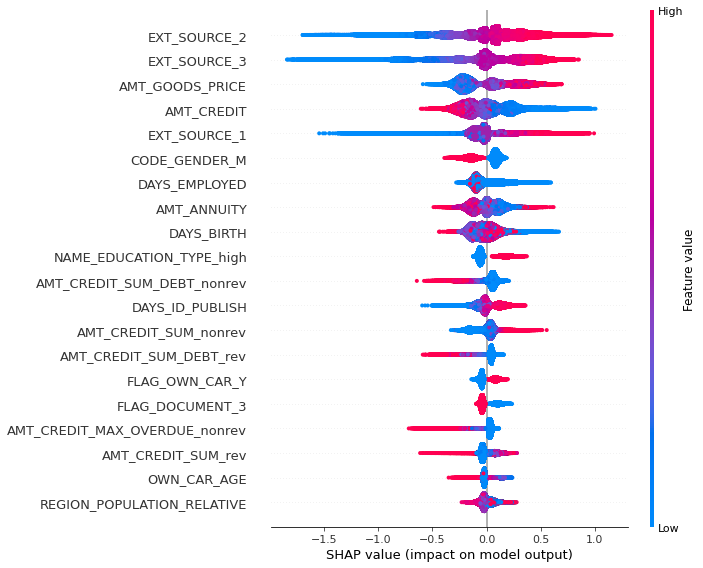

In [23]:
shap.summary_plot(shap_values[0], features=X, feature_names=X.columns)

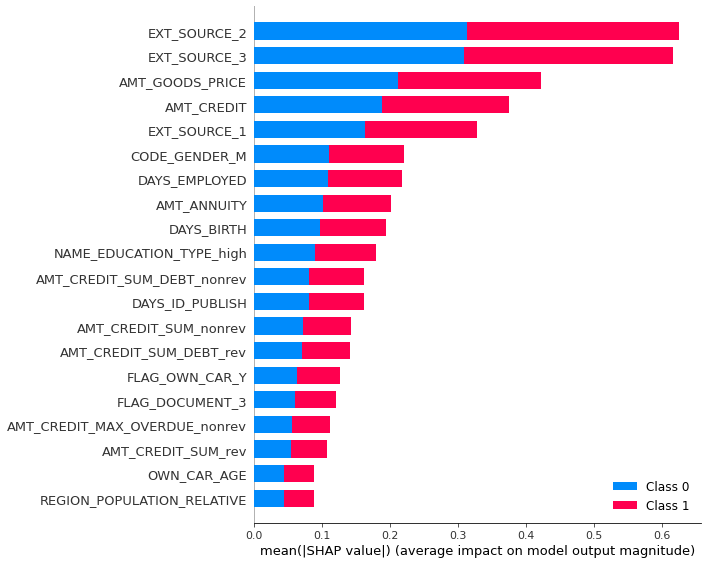

In [25]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [18]:
get_scores(lgbm, X_test, y_test)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.75      0.05      0.09      4965

    accuracy                           0.92     61503
   macro avg       0.83      0.52      0.52     61503
weighted avg       0.91      0.92      0.89     61503



In [19]:
get_scores(lgbm, X_train, y_train)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.71      0.04      0.07     19860

    accuracy                           0.92    246008
   macro avg       0.82      0.52      0.52    246008
weighted avg       0.91      0.92      0.89    246008



In [107]:
pred = get_output(lgbm, test)

In [108]:
pd.DataFrame(pred[:,1], index =  test.index, columns = ['TARGET']).to_csv('lightgbm_sub_1.csv')

In [93]:
test.drop(columns = 'Unnamed: 0', inplace = True )